# LeNet Lab Solution
![LeNet Architecture](lenet.png)
Source: Yan LeCun

## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [45]:
# Load pickled data
import pickle
import math

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../traffic-signs-data/train.p'
validation_file='../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']



The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

You do not need to modify this section.

In [46]:
import numpy as np

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))

print("Updated Image Shape: {}".format(X_train[0].shape))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples
Updated Image Shape: (32, 32, 3)


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

25


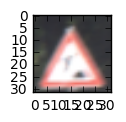

In [47]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [48]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [49]:
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 128

## SOLUTION: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [57]:
from tensorflow.contrib.layers import flatten

def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_everages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_everages

def no_batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    return Ylogits, tf.no_op()

def compatible_convolutional_noise_shape(Y):
    noiseshape = tf.shape(Y)
    noiseshape = noiseshape * tf.constant([1,0,0,1]) + tf.constant([0,1,1,0])
    return noiseshape

def create_classifier(x, n_classes): 
    # weight inits parameters (truncated normal)
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # Layer 2: Convolutional. Output = 24x24x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 24x24x16. Output = 12x12x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Dropout
    conv2 = tf.nn.dropout(conv2, pkeep_conv)

    
    # Layer 3: Convolutional. Input = 12x12x16. Output = 8x8x64.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)

    # Layer 4: Convolutional. Output = 4x4x128.
    conv4_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 128), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(128))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    conv4 = tf.nn.relu(conv4)
    # Pooling. Input = 4x4x128. Output = 2x2x128.
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Dropout
    conv4 = tf.nn.dropout(conv4, pkeep_conv)

    
    # Flatten. Input = 2x2x128. Output = 512.
    fc0   = flatten(conv4)
    
    # Layer 3: Fully Connected. Input = 512. Output = 256.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(512, 256), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(256))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 256. Output = 64.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(256, 64), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(64))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 64. Output = number of classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(64, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    #conv1, update_ema1 = batchnorm(conv1, tst, iter, conv1_b, convolutional=True)
    
    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv1 = tf.nn.dropout(conv1, pkeep_conv, compatible_convolutional_noise_shape(conv1))

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #conv2, update_ema2 = batchnorm(conv2, tst, iter, conv2_b, convolutional=True)                   
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2 = tf.nn.dropout(conv2, pkeep_conv, compatible_convolutional_noise_shape(conv2))
                           
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2) 
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(200))
    fc2   = tf.matmul(fc0, fc2_W) + fc2_b
    #fc1, update_ema3 = batchnorm(fc1, tst, iter, fc1_b)
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    fc2 = tf.nn.dropout(fc2, pkeep)
    
    
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(200, 120), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(120))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    #fc2, update_ema4 = batchnorm(fc2, tst, iter, fc2_b)
    
    # SOLUTION: Activation.
    fc3    = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3, pkeep)
    
     # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(84))
    fc4    = tf.matmul(fc3, fc4_W) + fc4_b
    #fc2, update_ema4 = batchnorm(fc2, tst, iter, fc2_b)
    
    # SOLUTION: Activation.
    fc4    = tf.nn.relu(fc4)
    fc4 = tf.nn.dropout(fc4, pkeep)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc5_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc5_b  = tf.Variable(tf.zeros(43))
    
    logits = tf.matmul(fc4, fc5_W) + fc5_b
    #logits = tf.nn.dropout(logits, pkeep)
    #update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [1]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
# test flag for batch norm
tst = tf.placeholder(tf.bool)
iter = tf.placeholder(tf.int32)
# dropout probability
pkeep = tf.placeholder(tf.float32)
pkeep_conv = tf.placeholder(tf.float32)
# variable learning rate
lr = tf.placeholder(tf.float32)

NameError: name 'tf' is not defined

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [59]:
logits = create_classifier(x,43)
#update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(lr)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [60]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,tst: True, pkeep: 1, pkeep_conv: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [61]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        max_learning_rate = 0.002
        min_learning_rate = 0.0001
        decay_speed = 100
        learning_rate = round(min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed),4)
        print(learning_rate)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y ,lr: learning_rate,pkeep: 0.75, pkeep_conv: 1.0,iteration:i})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

0.002
EPOCH 1 ...
Validation Accuracy = 0.251

0.002
EPOCH 2 ...
Validation Accuracy = 0.736

0.002
EPOCH 3 ...
Validation Accuracy = 0.859

0.0019
EPOCH 4 ...
Validation Accuracy = 0.903

0.0019
EPOCH 5 ...
Validation Accuracy = 0.903

0.0019
EPOCH 6 ...
Validation Accuracy = 0.915

0.0019
EPOCH 7 ...
Validation Accuracy = 0.917

0.0019
EPOCH 8 ...
Validation Accuracy = 0.920

0.0019
EPOCH 9 ...
Validation Accuracy = 0.921

0.0018
EPOCH 10 ...
Validation Accuracy = 0.909

0.0018
EPOCH 11 ...
Validation Accuracy = 0.921

0.0018
EPOCH 12 ...
Validation Accuracy = 0.923

0.0018
EPOCH 13 ...
Validation Accuracy = 0.931

0.0018
EPOCH 14 ...
Validation Accuracy = 0.920

0.0018
EPOCH 15 ...
Validation Accuracy = 0.933

0.0017
EPOCH 16 ...
Validation Accuracy = 0.933

0.0017
EPOCH 17 ...
Validation Accuracy = 0.948

0.0017
EPOCH 18 ...
Validation Accuracy = 0.910

0.0017
EPOCH 19 ...
Validation Accuracy = 0.907

0.0017
EPOCH 20 ...
Validation Accuracy = 0.937

0.0017
EPOCH 21 ...

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [63]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.947
